In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, InsetPosition, mark_inset
from matplotlib.legend_handler import HandlerTuple
%run config_10.py

Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 20})

In [3]:
nBins = 30
nContourLevels = 3
# 2d contour levels: (68%, 95%, 99%)
confLevels = [.3173, .0455, .0027]
confLevels_grid = [-6.18/2,-4.61/2,-2.30/2,0]

smoothingKernel = 1
filledPlots = True
truthColors = np.expand_dims(np.array('black'), axis=0)
truthLineStyles = np.expand_dims(np.array('--'), axis=0)
plotDensity = False
figureWidth = 8

colorsDict = {
              # Match pygtc up to v0.2.4
              'blues_old' : ('#4c72b0','#7fa5e3','#b2d8ff'),
              'greens_old' : ('#55a868','#88db9b','#bbffce'),
              'yellows_old' : ('#f5964f','#ffc982','#fffcb5'),
              'reds_old' : ('#c44e52','#f78185','#ffb4b8'),
              'purples_old' : ('#8172b2','#b4a5e5','#37d8ff'),
              # New color scheme, dark colors match matplotlib v2
              'blues' : ('#1f77b4','#52aae7','#85ddff'),
              'oranges' : ('#ff7f0e','#ffb241','#ffe574'),
              'greens' : ('#2ca02c','#5fd35f','#92ff92'),
              'reds' : ('#d62728','#ff5a5b','#ff8d8e'),
              'purples' : ('#9467bd','#c79af0','#facdff'),
              'browns' : ('#8c564b','#bf897e','#f2bcb1'),
              'pinks' : ('#e377c2','#ffaaf5','#ffddff'),
              'grays' : ('#7f7f7f','#b2b2b2','#e5e5e5'),
              'yellows' : ('#bcbd22','#eff055','#ffff88'),
              'cyans' : ('#17becf','#4af1ff','#7dffff'),
          }
defaultColorsOrder = ['blues', 'oranges','greens', 'reds', 'purples',
                    'browns', 'pinks', 'grays', 'yellows', 'cyans']
colorsOrder = defaultColorsOrder
colors = [colorsDict[cs] for cs in colorsOrder]

def CustomCmap(to_rgb):
    import matplotlib.colors as mplcolors
    from matplotlib.colors import LinearSegmentedColormap
    # from color r,g,b
    r1,g1,b1 = 1,1,1
    # to color r,g,b
    r2,g2,b2 = mplcolors.hex2color(to_rgb)

    cdict = {'red': ((0, r1, r1), (1, r2, r2)),
           'green': ((0, g1, g1), (1, g2, g2)),
           'blue': ((0, b1, b1), (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

def setCustomColorMaps(colors):
    customColorMaps = [CustomCmap(color[0]) for color in colors]
    return customColorMaps

myColorMap = setCustomColorMaps(colors)

def plot2d(ax, nChains, chains2d, weights, nBins, smoothingKernel,
            filledPlots, colors, nContourLevels, confLevels, truths2d,
            truthColors, truthLineStyles, plotDensity, myColorMap):
    import scipy.ndimage
    
    # Empty arrays needed below
    chainLevels = np.ones((nChains,nContourLevels+1))
    extents = np.empty((nChains,4))

    # These are needed to compute the contour levels
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    ##### The filled contour plots
    plotData = []
    # Draw filled contours in reversed order to have first chain in list on top
    for k in reversed(range(nChains)):
        # Is there a chain to plot?
        if (np.isnan(chains2d[k][0]).all())|(np.isnan(chains2d[k][1]).all()):
            plotData.append(None)
        else:
            # Create 2d histogram
            hist2d, xedges, yedges = np.histogram2d(
                chains2d[k][0], chains2d[k][1], weights=weights[k], bins=nBins)
            # image extent, needed below for contour lines
            extents[k] = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            # Normalize
            hist2d = hist2d/np.sum(hist2d)
            # Cumulative 1d distribution
            histOrdered = np.sort(hist2d.flat)
            histCumulative = np.cumsum(histOrdered)

            # Compute contour levels (from low to high for technical reasons)
            for l in range(nContourLevels):
                # Find location of contour level in 1d histCumulative
                temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
                # Find "height" of contour level
                chainLevels[k][nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

            # Apply Gaussian smoothing and plot filled contours if requested
            if smoothingKernel>0:
                plotData.append( scipy.ndimage.gaussian_filter(hist2d.T, sigma=smoothingKernel) )
            else:
                plotData.append( hist2d.T )
            if filledPlots:
                xbins = (xedges[1:]+xedges[:-1])/2
                ybins = (yedges[1:]+yedges[:-1])/2
                ax.contourf(xbins, ybins, plotData[-1], levels=chainLevels[k],
                    colors=colors[k][:nContourLevels][::-1])

            # Plot density
            if plotDensity:
                if filledPlots:
                    ax.imshow(hist2d.T, extent=extents[k], origin='lower',
                        cmap=myColorMap[k], aspect='auto', clim=(0,chainLevels[k][0]))
                else:
                    ax.imshow(hist2d.T, extent=extents[k], origin='lower',
                        cmap=myColorMap[k], aspect='auto')


    ###### Draw contour lines in order to see contours lying on top of each other
    for k in range(nChains):
        if plotData[nChains-1-k] is not None:
            for l in range(nContourLevels):
                ax.contour(plotData[nChains-1-k], [chainLevels[k][nContourLevels-1-l]],
                    extent=extents[k], origin='lower', linewidths=1, colors=colors[k][l])

    ##### Truth lines
    if truths2d is not None:
        for k in range(len(truths2d)):
            # horizontal line
            if truths2d[k][0] is not None:
                ax.axhline(truths2d[k][0], lw=1, color=truthColors[k], ls=truthLineStyles[k])
            # vertical line
            if truths2d[k][1] is not None:
                ax.axvline(truths2d[k][1], lw=1, color=truthColors[k], ls=truthLineStyles[k])

    return ax

In [4]:
lognormfields=np.load(simsout+'.npy')
T=np.load(dataout+'_mean_cov_theory.npz')
average_r, mean2pt, cov, xiLN = T['average_r'], T['mean2pt'], T['cov'], T['xiLN']
dxiLN_dalpha, dxiLN_dbeta = T['dxiLN_dalpha'], T['dxiLN_dbeta']

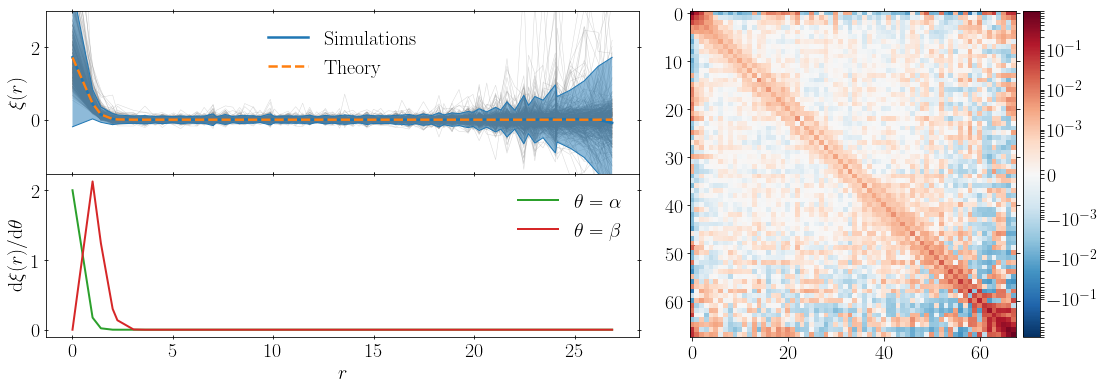

In [5]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, 2, hspace=0., wspace=-0.12)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_ylabel('$\\xi(r)$')
ax0.set_ylim([-1.5,3])
ax0.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax0.tick_params(axis="y",direction="inout",left=True,right=True)
plt.setp(ax0.get_xticklabels(), visible=False)

for i in range(nsims):
    ax0.plot(average_r,lognormfields[i]['corrfn'],color="grey",lw=0.5,alpha=0.3,zorder=0.5)

# Plot the mean correlation function:
ax0.plot(average_r,mean2pt,lw=2.5,label="Simulations")

# Plot the diagonal of the covariance matrix.  Wild fluctuations are from varying numbers of pairs per bin
ax0.fill_between(average_r,mean2pt-2*np.sqrt(np.diag(cov)),mean2pt+2*np.sqrt(np.diag(cov)),alpha=0.5)
ax0.plot(average_r,mean2pt-2*np.sqrt(np.diag(cov)),c='C0',lw=1.)
ax0.plot(average_r,mean2pt+2*np.sqrt(np.diag(cov)),c='C0',lw=1.)

# Plot the mean correlation function and the theory with the correct alpha, beta :
ax0.plot(average_r,xiLN,ls='--',lw=2.5,label="Theory")
ax0.legend(loc='best',frameon=False)

ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
ax1.set_xlabel('$r$')
ax1.set_ylabel('$\\mathrm{d}\\xi(r)/\\mathrm{d}\\theta$')
ax1.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax1.tick_params(axis="y",direction="inout",left=True,right=True)

# Plot the gradients
ax1.plot(average_r,dxiLN_dalpha,label="$\\theta=\\alpha$",color='C2')
ax1.plot(average_r,dxiLN_dbeta,label="$\\theta=\\beta$",color='C3')
ax1.legend(loc='best',frameon=False)

# Plot the covariance matrix
ax2 = fig.add_subplot(gs[:,-1])
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)

im2 = ax2.pcolormesh(np.arange(cov.shape[0]), np.arange(cov.shape[1]), cov,
                       norm=mcolors.SymLogNorm(linthresh=1e-4, linscale=0.1,
                                              vmin=-cov.max(), vmax=cov.max(), base=10),
                       cmap='RdBu_r', shading='auto')

ax2.invert_yaxis()
ax2.set_aspect('equal')
d2 = make_axes_locatable(ax2)
cax2 = d2.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im2, cax=cax2)
tick_labels=np.array([item.get_text() for item in cbar.ax.get_yticklabels()])
tick_labels=np.where(tick_labels=='$\\mathdefault{10^{-4}}$','',tick_labels)
tick_labels=np.where(tick_labels=='$\\mathdefault{-10^{-4}}$','',tick_labels)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(tick_labels)

plt.savefig(fileout+'_corrfn.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_corrfn.png',dpi=100,bbox_inches="tight")

In [6]:
nfields = 4
dataid = 0

# Simulation pool
P=np.load(dataout+'_sbi_pool.npz')
alpha_pool, beta_pool, comp_pool = P['alpha_pool'], P['beta_pool'], P['comp_pool']

# 2PCF, simulation-based inference
epsilon = 0.05
A=np.load(dataout+'_sbi_field'+str(dataid)+'.npz')
epsilons, sample_size, alpha_marginal_stds, beta_marginal_stds = \
    A['epsilons'], A['sample_size'], A['alpha_marginal_stds'], A['beta_marginal_stds']
AA=np.load(dataout+'_sbi_field'+str(dataid)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz')
sbi_samples, sbi_weights, disc_samples = AA['samples'], AA['weights'], AA['disc']
alpha_samples, beta_samples = sbi_samples.T[0], sbi_samples.T[1]
C = np.load(dataout+'_sbi_eps'+str(int(100*epsilon))+'_'+str(nfields)+'fields.npz')
alphas_sbi, betas_sbi, sbi_lnL0, sbi_lnL1, sbi_lnL2, sbi_lnL3, sbi_lnL =\
    C['alphas'], C['betas'], C['lnL0'], C['lnL1'], C['lnL2'], C['lnL3'], C['lnL']

# 2PCF, likelihood-based analysis
B = np.load(dataout+'_summaries_'+str(nfields)+'fields.npz')
alphas_sum, betas_sum, sum_lnL0, sum_lnL1, sum_lnL2, sum_lnL3, sum_lnL =\
    B['alphas'], B['betas'], B['lnL0'], B['lnL1'], B['lnL2'], B['lnL3'], B['lnL']

# Full field, data assimilation
D = np.load(dataout+'_da_'+str(dataid)+'.npz')
da_samples, da_weights = D['samples'], D['weights']
DD = np.load(dataout+'_da_kde.npz')
alphas_da, betas_da, da_lnL0, da_lnL1, da_lnL2, da_lnL3, da_lnL =\
    DD['alphas'], DD['betas'], DD['lnL0'], DD['lnL1'], DD['lnL2'], DD['lnL3'], DD['lnL']

truths2d = np.expand_dims(np.array([beta,alpha]), axis=0)

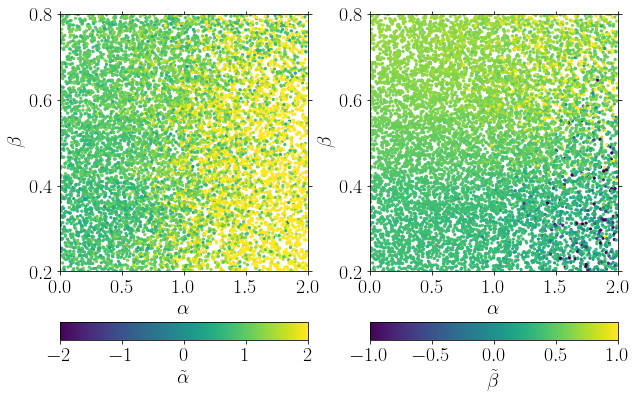

In [7]:
N=10000
fig=plt.figure(figsize=(10,6))

ax0=fig.add_subplot(1,2,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
im0 = ax0.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[0], s=5., vmin=-2., vmax=2.)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.ax.set_xlabel("$\\tilde{\\alpha}$")

ax1=fig.add_subplot(1,2,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
im1 = ax1.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[1], s=5., vmin=-1., vmax=1.)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.7)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.ax.set_xlabel("$\\tilde{\\beta}$")

plt.subplots_adjust(wspace=0.25)
plt.savefig(fileout+'_simulations.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_simulations.png',dpi=100,bbox_inches="tight")

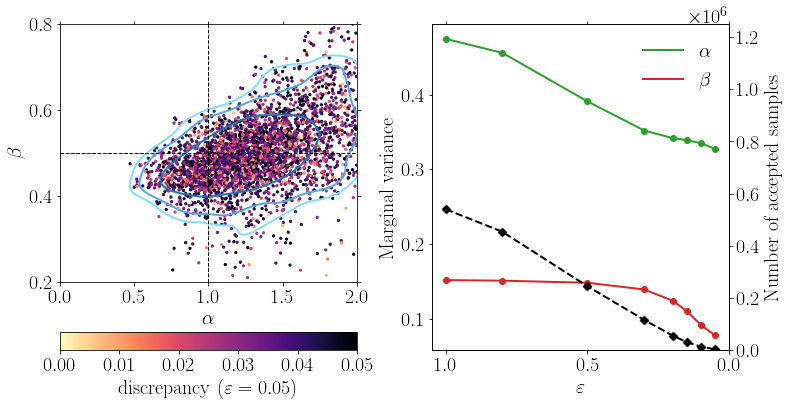

In [8]:
N=10000
fig=plt.figure(figsize=(12,6))

ax0=fig.add_subplot(1,2,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax0.axhline(beta,lw=1,ls="--",color="k",zorder=5)
im0 = ax0.scatter(alpha_samples[:N], beta_samples[:N], c=disc_samples[:N], s=5., vmin=0, vmax=0.05, cmap='magma_r')
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]))
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_ticks([0,0.01,0.02,0.03,0.04,0.05])
cb0.ax.set_xlabel("discrepancy ($\\varepsilon=0.05$)")

ax1=fig.add_subplot(1,2,2)
ax1.set_xlim([1.05,0])
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.set_xlabel("$\\varepsilon$")
ax1.set_ylabel("Marginal variance")
ax1.scatter(epsilons,alpha_marginal_stds,marker='o',color='C2')
ax1.plot(epsilons,alpha_marginal_stds,ls='-',color='C2',label='$\\alpha$')
ax1.scatter(epsilons,beta_marginal_stds,marker='o',color='C3')
ax1.plot(epsilons,beta_marginal_stds,ls='-',color='C3',label="$\\beta$")

ax2=ax1.twinx()
ax2.set_ylim(0,1.25e6)
ax2.set_ylabel("Number of accepted samples")
ax2.scatter(epsilons,sample_size,marker='D',color='k')
ax2.plot(epsilons,sample_size,ls='--',color='k')

ax1.legend(loc="best",frameon=False)

plt.subplots_adjust(wspace=0.25)
plt.savefig(fileout+'_sbi.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_sbi.png',dpi=100,bbox_inches="tight")

In [9]:
data={}
posterior_mean={}
difference={}
rhat_field={}

for f in range(nfields):
    F = np.load(dataout+'_da_fields_'+str(f)+'.npz')
    data[f], posterior_mean[f], difference[f], rhat_field[f] = F['data'], F['posterior_mean'], F['difference'], F['rhat_field']

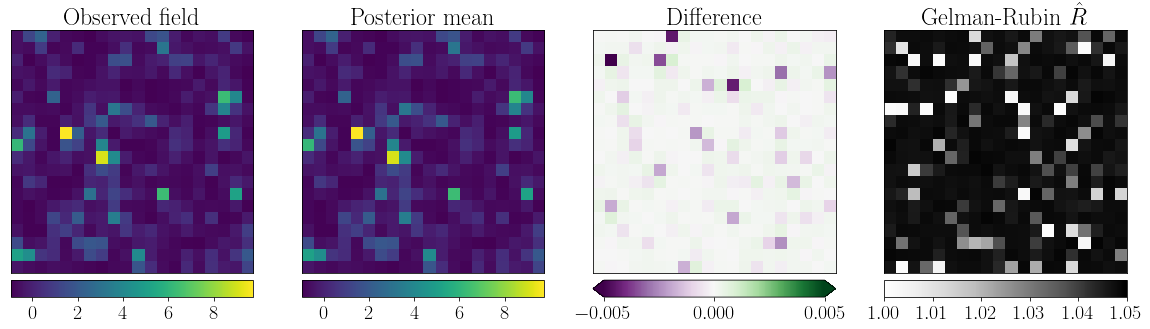

In [10]:
f=0

fig=plt.figure(figsize=(20,6))
ax0=fig.add_subplot(1,4,1)
ax0.set_xticks([])
ax0.set_yticks([])
im0 = ax0.imshow(data[f], cmap='viridis', vmin=np.min((data[f].min(),posterior_mean[f].min())), vmax=np.max((data[f].max(),posterior_mean[f].max())))
ax0.set_title("Observed field")
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.1)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_ticks([0,2,4,6,8])

ax1=fig.add_subplot(1,4,2)
ax1.set_xticks([])
ax1.set_yticks([])
im1 = ax1.imshow(posterior_mean[f], cmap='viridis', vmin=np.min((data[f].min(),posterior_mean[f].min())), vmax=np.max((data[f].max(),posterior_mean[f].max())))
ax1.set_title("Posterior mean")
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.1)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.set_ticks([0,2,4,6,8])

ax2=fig.add_subplot(1,4,3)
ax2.set_xticks([])
ax2.set_yticks([])
im2 = ax2.imshow(difference[f], cmap='PRGn', vmin=-0.005, vmax=0.005)
ax2.set_title("Difference")
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad=0.1)
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", extend='both')
cb2.set_ticks([-0.005,0.,0.005])

ax3=fig.add_subplot(1,4,4)
ax3.set_xticks([])
ax3.set_yticks([])
im3 = ax3.imshow(rhat_field[f], cmap='Greys', vmin=1., vmax=1.05)
ax3.set_title("Gelman-Rubin $\\hat{R}$")
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("bottom", size="7%", pad=0.1)
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")
cb3.set_ticks([1,1.01,1.02,1.03,1.04,1.05])

plt.savefig(fileout+'_fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_fields.png',dpi=100,bbox_inches="tight")

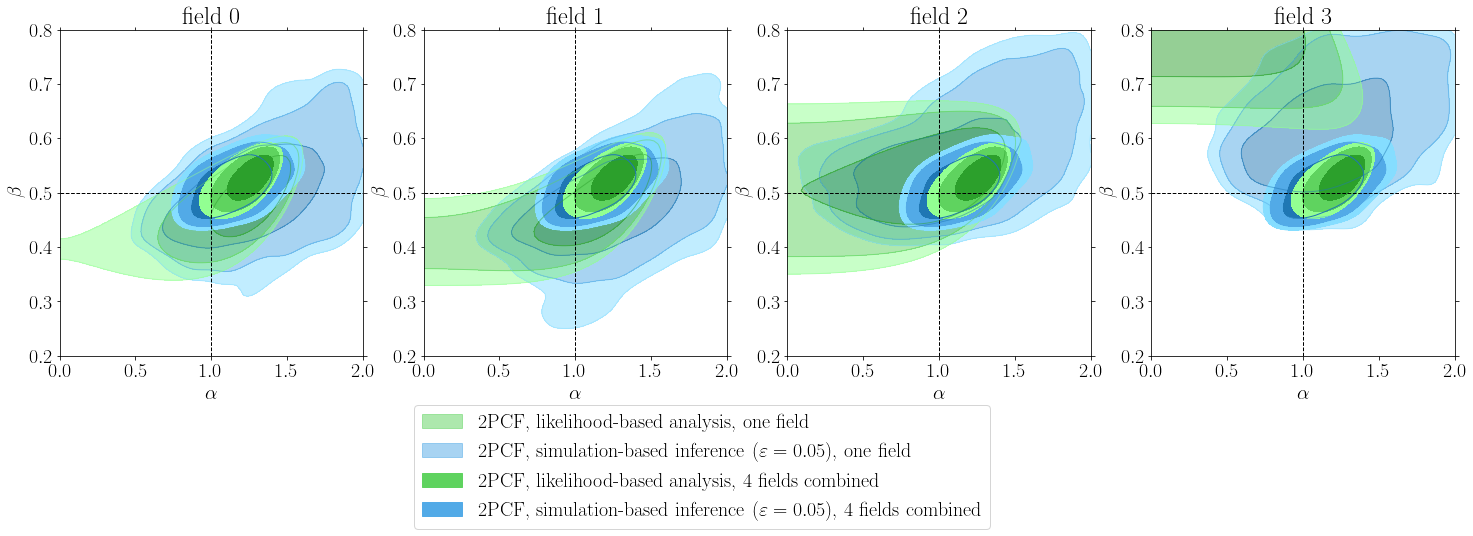

In [11]:
fig=plt.figure(figsize=(25,6))

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_title("field 0")
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax0.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax0.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax0.contour(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_title("field 1")
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax1.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax1.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1, confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax1.contour(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_title("field 2")
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax2.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax2.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2, confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax2.contour(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_title("field 3")
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax3.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax3.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3, confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax3.contour(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

patch1a = mpatches.Patch(color=colors[2][1], alpha=0.5, label='2PCF, likelihood-based analysis, one field')
patch2a = mpatches.Patch(color=colors[0][1], alpha=0.5, label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$), one field')
patch1b = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis, 4 fields combined')
patch2b = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$), 4 fields combined')
plt.legend(handles=[patch1a,patch2a,patch1b,patch2b],bbox_to_anchor=(-0.5, -0.12))

plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb.png',dpi=100,bbox_inches="tight")

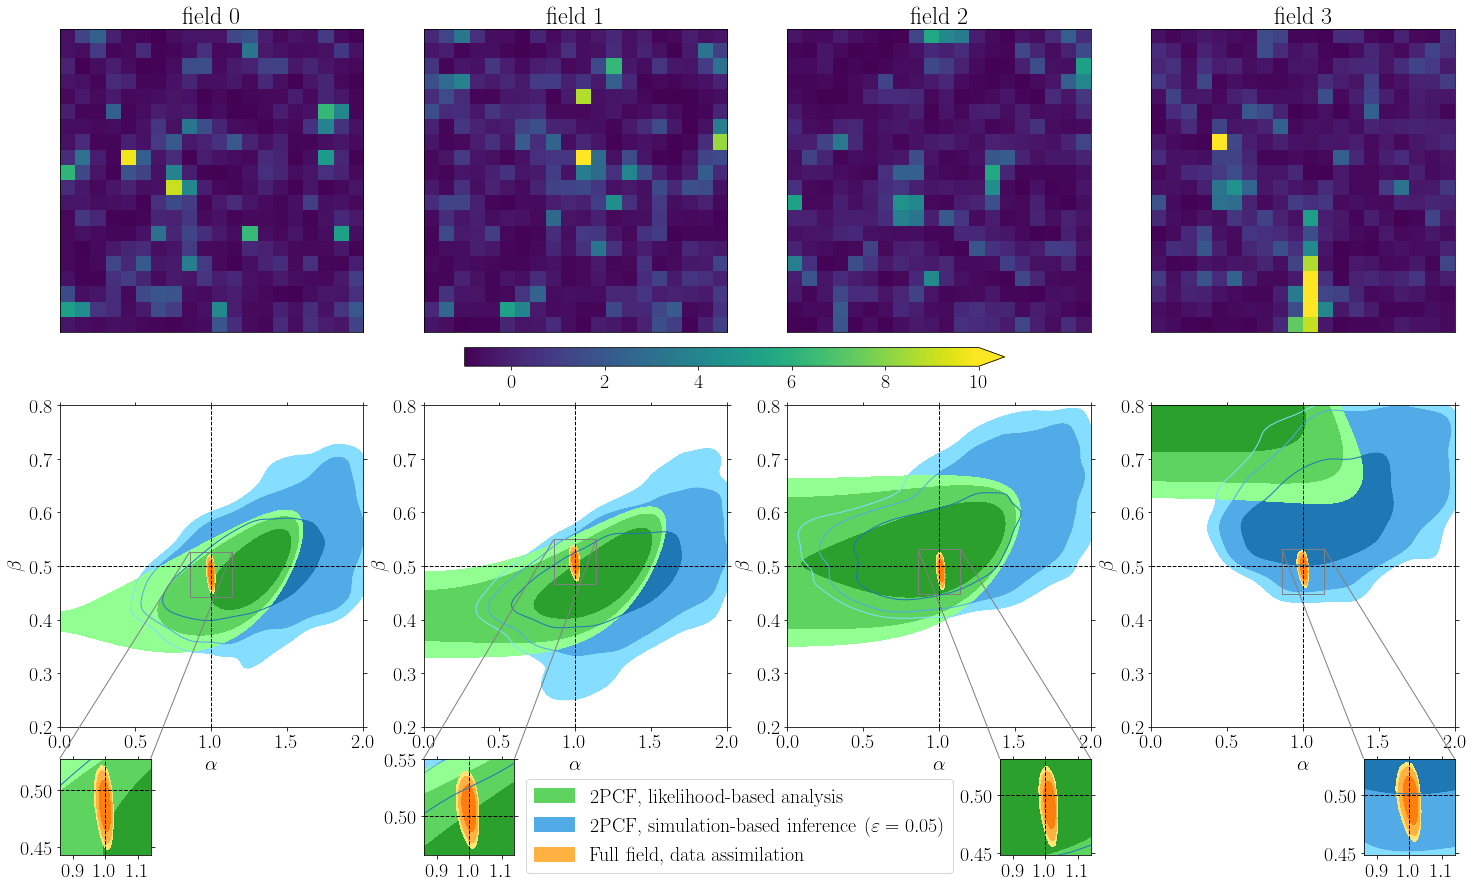

In [12]:
fig=plt.figure(figsize=(25,13))
inset_size=0.07

vmin=-1.
vmax=10.

axA=fig.add_subplot(2,4,1)
axA.set_title("field 0")
axA.set_xticks([])
axA.set_yticks([])
imA = axA.imshow(data[0], cmap='viridis', vmin=vmin, vmax=vmax)
axB=fig.add_subplot(2,4,2)
axB.set_title("field 1")
axB.set_xticks([])
axB.set_yticks([])
imB = axB.imshow(data[1], cmap='viridis', vmin=vmin, vmax=vmax)
axC=fig.add_subplot(2,4,3)
axC.set_title("field 2")
axC.set_xticks([])
axC.set_yticks([])
imC = axC.imshow(data[2], cmap='viridis', vmin=vmin, vmax=vmax)
axD=fig.add_subplot(2,4,4)
axD.set_title("field 3")
axD.set_xticks([])
axD.set_yticks([])
imD = axD.imshow(data[3], cmap='viridis', vmin=vmin, vmax=vmax)

cbar_ax = fig.add_axes([0.35, 0.51, 0.3, 0.02])
cb = fig.colorbar(imD, cax=cbar_ax, orientation="horizontal", extend="max")

ax0=fig.add_subplot(2,4,5)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]))
ax0.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax0b=fig.add_axes([0,0,1,1], label="ax0b")
ip0=InsetPosition(ax0, [0.,-0.4,0.3,0.3])
ax0b.set_axes_locator(ip0)
ax0b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.485
ax0b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax0b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax0b.axvline(alpha,lw=1,ls="--",color="k")
ax0b.axhline(beta,lw=1,ls="--",color="k")
ax0b.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]))
ax0b.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0b.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))
ax0b.contour(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax0, ax0b, loc1=1, loc2=2, fc="none", ec="0.5", ls=None)

ax1=fig.add_subplot(2,4,6)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1, confLevels_grid, colors=np.flip(colors[0]))
ax1.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1.contourf(alphas_da, betas_da, da_lnL1, confLevels_grid, colors=np.flip(colors[1]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax1b = fig.add_axes([0,0,1,1], label="ax1b")
ip1 = InsetPosition(ax1, [0.,-0.4,0.3,0.3])
ax1b.set_axes_locator(ip1)
ax1b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.508
ax1b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax1b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax1b.axvline(alpha,lw=1,ls="--",color="k")
ax1b.axhline(beta,lw=1,ls="--",color="k")
ax1b.contourf(alphas_sbi, betas_sbi, sbi_lnL1, confLevels_grid, colors=np.flip(colors[0]))
ax1b.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1b.contourf(alphas_da, betas_da, da_lnL1, confLevels_grid, colors=np.flip(colors[1]))
ax1b.contour(alphas_sbi, betas_sbi, sbi_lnL1, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax1, ax1b, loc1=1, loc2=2, fc="none", ec='0.5')

ax2=fig.add_subplot(2,4,7)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2, confLevels_grid, colors=np.flip(colors[0]))
ax2.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2.contourf(alphas_da, betas_da, da_lnL2, confLevels_grid, colors=np.flip(colors[1]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax2b=fig.add_axes([0,0,1,1], label="ax2b")
ip2=InsetPosition(ax2, [0.7,-0.4,0.3,0.3])
ax2b.set_axes_locator(ip2)
ax2b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.49
ax2b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax2b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax2b.axvline(alpha,lw=1,ls="--",color="k")
ax2b.axhline(beta,lw=1,ls="--",color="k")
ax2b.contourf(alphas_sbi, betas_sbi, sbi_lnL2, confLevels_grid, colors=np.flip(colors[0]))
ax2b.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2b.contourf(alphas_da, betas_da, da_lnL2, confLevels_grid, colors=np.flip(colors[1]))
ax2b.contour(alphas_sbi, betas_sbi, sbi_lnL2, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax2, ax2b, loc1=1, loc2=2, fc="none", ec='0.5')

ax3=fig.add_subplot(2,4,8)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3, confLevels_grid, colors=np.flip(colors[0]))
ax3.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3.contourf(alphas_da, betas_da, da_lnL3, confLevels_grid, colors=np.flip(colors[1]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax3b=fig.add_axes([0,0,1,1], label="ax3b")
ip3=InsetPosition(ax3, [0.7,-0.4,0.3,0.3])
ax3b.set_axes_locator(ip3)
ax3b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.49
ax3b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax3b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax3b.axvline(alpha,lw=1,ls="--",color="k")
ax3b.axhline(beta,lw=1,ls="--",color="k")
ax3b.contourf(alphas_sbi, betas_sbi, sbi_lnL3, confLevels_grid, colors=np.flip(colors[0]))
ax3b.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3b.contourf(alphas_da, betas_da, da_lnL3, confLevels_grid, colors=np.flip(colors[1]))
ax3b.contour(alphas_sbi, betas_sbi, sbi_lnL3, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax3, ax3b, loc1=1, loc2=2, fc="none", ec='0.5')

patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
fig.legend(handles=[patch1,patch2,patch3],bbox_to_anchor=(0.627, 0.08))

plt.savefig(fileout+'_fields_posterior_sbi_da_'+str(nfields)+'fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_fields_posterior_sbi_da_'+str(nfields)+'fields.png',dpi=100,bbox_inches="tight")

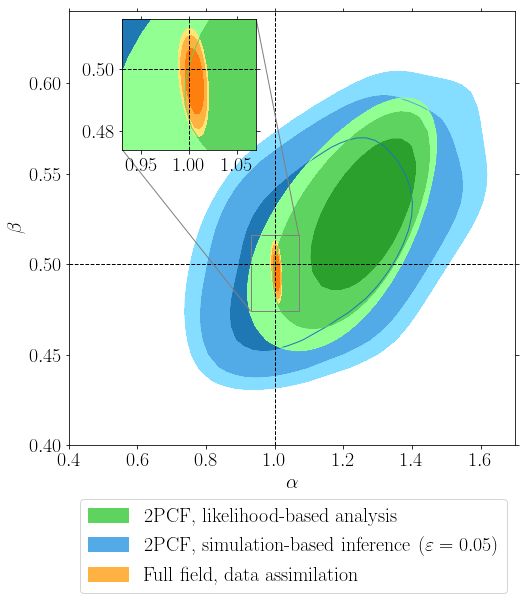

In [13]:
fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.7])
ax.set_ylim([0.4,0.64])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Single field
# ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
# ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]))

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))

# Foregrounds
ax.contour(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)

inset_size = 0.035
axb=fig.add_axes([0,0,1,1], label="ax0b")
ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
axb.set_axes_locator(ip)
axb.tick_params(axis="x",direction="out",bottom=True,top=True)
axb.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.495
axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
axb.axvline(alpha,lw=1,ls="--",color="k")
axb.axhline(beta,lw=1,ls="--",color="k")
axb.contourf(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]))
axb.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
axb.contour(alphas_sbi, betas_sbi, sbi_lnL, confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
axb.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend 1
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
# plt.legend(handles=[patch1,patch2],loc='lower left')
plt.legend(handles=[patch1,patch2,patch3],bbox_to_anchor=(2.95, -2.6))

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields_comb.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields_comb.png',dpi=100,bbox_inches="tight")

In [14]:
%run config_02.py

Figures saved at figures/Output20_05_02_80_80_500_80_1_123457
Simulations saved at data/Sims20_05_02_80_80_500_80_1_123457


In [15]:
lognormfields=np.load(simsout+'.npy')
T=np.load(dataout+'_mean_cov_theory.npz')
average_r, mean2pt, cov, xiLN = T['average_r'], T['mean2pt'], T['cov'], T['xiLN']
dxiLN_dalpha, dxiLN_dbeta = T['dxiLN_dalpha'], T['dxiLN_dbeta']

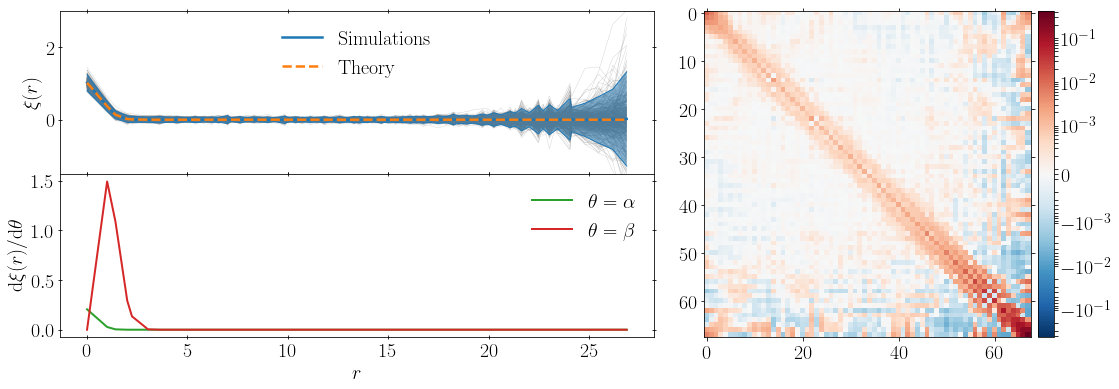

In [16]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, 2, hspace=0., wspace=-0.12)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_ylabel('$\\xi(r)$')
ax0.set_ylim([-1.5,3])
ax0.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax0.tick_params(axis="y",direction="inout",left=True,right=True)
plt.setp(ax0.get_xticklabels(), visible=False)

for i in range(nsims):
    ax0.plot(average_r,lognormfields[i]['corrfn'],color="grey",lw=0.5,alpha=0.3,zorder=0.5)

# Plot the mean correlation function:
ax0.plot(average_r,mean2pt,lw=2.5,label="Simulations")

# Plot the diagonal of the covariance matrix.  Wild fluctuations are from varying numbers of pairs per bin
ax0.fill_between(average_r,mean2pt-2*np.sqrt(np.diag(cov)),mean2pt+2*np.sqrt(np.diag(cov)),alpha=0.5)
ax0.plot(average_r,mean2pt-2*np.sqrt(np.diag(cov)),c='C0',lw=1.)
ax0.plot(average_r,mean2pt+2*np.sqrt(np.diag(cov)),c='C0',lw=1.)

# Plot the mean correlation function and the theory with the correct alpha, beta :
ax0.plot(average_r,xiLN,ls='--',lw=2.5,label="Theory")
ax0.legend(loc='best',frameon=False)

ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
ax1.set_xlabel('$r$')
ax1.set_ylabel('$\\mathrm{d}\\xi(r)/\\mathrm{d}\\theta$')
ax1.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax1.tick_params(axis="y",direction="inout",left=True,right=True)

# Plot the gradients
ax1.plot(average_r,dxiLN_dalpha,label="$\\theta=\\alpha$",color='C2')
ax1.plot(average_r,dxiLN_dbeta,label="$\\theta=\\beta$",color='C3')
ax1.legend(loc='best',frameon=False)

# Plot the covariance matrix
ax2 = fig.add_subplot(gs[:,-1])
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)

im2 = ax2.pcolormesh(np.arange(cov.shape[0]), np.arange(cov.shape[1]), cov,
                       norm=mcolors.SymLogNorm(linthresh=1e-4, linscale=0.1,
                                              vmin=-cov.max(), vmax=cov.max(), base=10),
                       cmap='RdBu_r', shading='auto')

ax2.invert_yaxis()
ax2.set_aspect('equal')
d2 = make_axes_locatable(ax2)
cax2 = d2.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im2, cax=cax2)
tick_labels=np.array([item.get_text() for item in cbar.ax.get_yticklabels()])
tick_labels=np.where(tick_labels=='$\\mathdefault{10^{-4}}$','',tick_labels)
tick_labels=np.where(tick_labels=='$\\mathdefault{-10^{-4}}$','',tick_labels)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(tick_labels)

plt.savefig(fileout+'_corrfn.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_corrfn.png',dpi=100,bbox_inches="tight")

In [17]:
nfields = 4
dataid = 0

# Simulation pool
P=np.load(dataout+'_sbi_pool.npz')
alpha_pool, beta_pool, comp_pool = P['alpha_pool'], P['beta_pool'], P['comp_pool']

# 2PCF, simulation-based inference
epsilon = 0.05
A=np.load(dataout+'_sbi_field'+str(dataid)+'.npz')
epsilons, sample_size, alpha_marginal_stds, beta_marginal_stds = \
    A['epsilons'], A['sample_size'], A['alpha_marginal_stds'], A['beta_marginal_stds']
AA=np.load(dataout+'_sbi_field'+str(dataid)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz')
sbi_samples, sbi_weights, disc_samples = AA['samples'], AA['weights'], AA['disc']
alpha_samples, beta_samples = sbi_samples.T[0], sbi_samples.T[1]
C = np.load(dataout+'_sbi_eps'+str(int(100*epsilon))+'_'+str(nfields)+'fields.npz')
alphas_sbi, betas_sbi, sbi_lnL0, sbi_lnL1, sbi_lnL2, sbi_lnL3, sbi_lnL =\
    C['alphas'], C['betas'], C['lnL0'], C['lnL1'], C['lnL2'], C['lnL3'], C['lnL']

# 2PCF, likelihood-based analysis
B = np.load(dataout+'_summaries_'+str(nfields)+'fields.npz')
alphas_sum, betas_sum, sum_lnL0, sum_lnL1, sum_lnL2, sum_lnL3, sum_lnL =\
    B['alphas'], B['betas'], B['lnL0'], B['lnL1'], B['lnL2'], B['lnL3'], B['lnL']

# Full field, data assimilation
D = np.load(dataout+'_da_'+str(dataid)+'.npz')
da_samples, da_weights = D['samples'], D['weights']
DD = np.load(dataout+'_da_kde.npz')
alphas_da, betas_da, da_lnL0, da_lnL1, da_lnL =\
    DD['alphas'], DD['betas'], DD['lnL0'], DD['lnL1'], DD['lnL']

truths2d = np.expand_dims(np.array([beta,alpha]), axis=0)

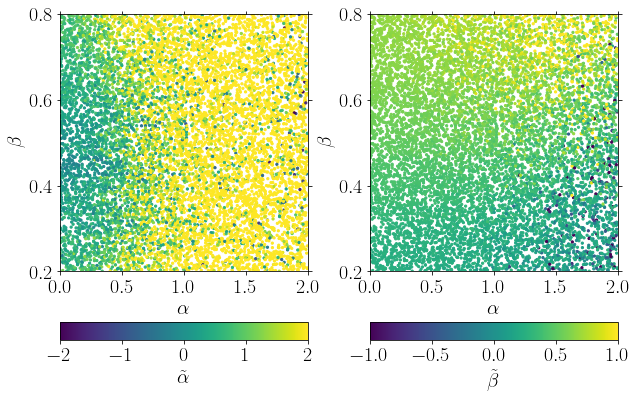

In [18]:
N=10000
fig=plt.figure(figsize=(10,6))

ax0=fig.add_subplot(1,2,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
im0 = ax0.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[0], s=5., vmin=-2., vmax=2.)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.ax.set_xlabel("$\\tilde{\\alpha}$")

ax1=fig.add_subplot(1,2,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
im1 = ax1.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[1], s=5., vmin=-1., vmax=1.)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.7)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.ax.set_xlabel("$\\tilde{\\beta}$")

plt.subplots_adjust(wspace=0.25)
plt.savefig(fileout+'_simulations.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_simulations.png',dpi=100,bbox_inches="tight")

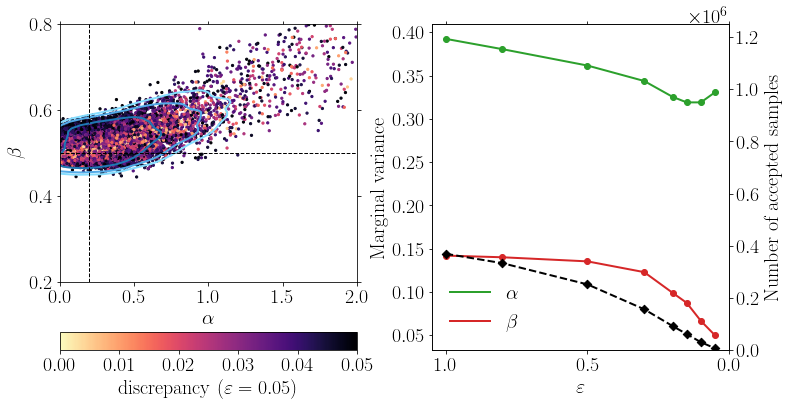

In [19]:
N=10000
fig=plt.figure(figsize=(12,6))

ax0=fig.add_subplot(1,2,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax0.axhline(beta,lw=1,ls="--",color="k",zorder=5)
im0 = ax0.scatter(alpha_samples[:N], beta_samples[:N], c=disc_samples[:N], s=5., vmin=0, vmax=0.05, cmap='magma_r')
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]))
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_ticks([0,0.01,0.02,0.03,0.04,0.05])
cb0.ax.set_xlabel("discrepancy ($\\varepsilon=0.05$)")

ax1=fig.add_subplot(1,2,2)
ax1.set_xlim([1.05,0])
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.set_xlabel("$\\varepsilon$")
ax1.set_ylabel("Marginal variance")
ax1.scatter(epsilons,alpha_marginal_stds,marker='o',color='C2')
ax1.plot(epsilons,alpha_marginal_stds,ls='-',color='C2',label='$\\alpha$')
ax1.scatter(epsilons,beta_marginal_stds,marker='o',color='C3')
ax1.plot(epsilons,beta_marginal_stds,ls='-',color='C3',label="$\\beta$")

ax2=ax1.twinx()
ax2.set_ylim(0,1.25e6)
ax2.set_ylabel("Number of accepted samples")
ax2.scatter(epsilons,sample_size,marker='D',color='k')
ax2.plot(epsilons,sample_size,ls='--',color='k')

ax1.legend(loc="best",frameon=False)

plt.subplots_adjust(wspace=0.25)
plt.savefig(fileout+'_sbi.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_sbi.png',dpi=100,bbox_inches="tight")

In [20]:
data={}
posterior_mean={}
difference={}
rhat_field={}

for f in range(2):
    F = np.load(dataout+'_da_fields_'+str(f)+'.npz')
    data[f], posterior_mean[f], difference[f], rhat_field[f] = F['data'], F['posterior_mean'], F['difference'], F['rhat_field']

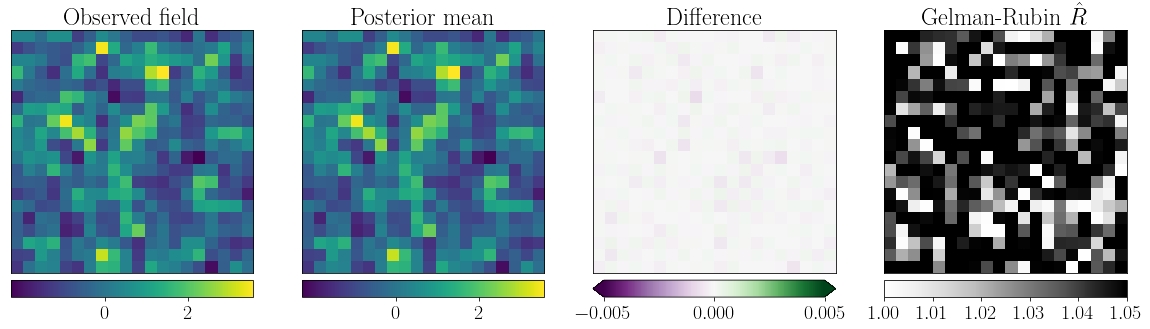

In [21]:
f=0

fig=plt.figure(figsize=(20,6))
ax0=fig.add_subplot(1,4,1)
ax0.set_xticks([])
ax0.set_yticks([])
im0 = ax0.imshow(data[f], cmap='viridis', vmin=np.min((data[f].min(),posterior_mean[f].min())), vmax=np.max((data[f].max(),posterior_mean[f].max())))
ax0.set_title("Observed field")
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.1)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_ticks([0,2,4,6,8])

ax1=fig.add_subplot(1,4,2)
ax1.set_xticks([])
ax1.set_yticks([])
im1 = ax1.imshow(posterior_mean[f], cmap='viridis', vmin=np.min((data[f].min(),posterior_mean[f].min())), vmax=np.max((data[f].max(),posterior_mean[f].max())))
ax1.set_title("Posterior mean")
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.1)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.set_ticks([0,2,4,6,8])

ax2=fig.add_subplot(1,4,3)
ax2.set_xticks([])
ax2.set_yticks([])
im2 = ax2.imshow(difference[f], cmap='PRGn', vmin=-0.005, vmax=0.005)
ax2.set_title("Difference")
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad=0.1)
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", extend='both')
cb2.set_ticks([-0.005,0.,0.005])

ax3=fig.add_subplot(1,4,4)
ax3.set_xticks([])
ax3.set_yticks([])
im3 = ax3.imshow(rhat_field[f], cmap='Greys', vmin=1., vmax=1.05)
ax3.set_title("Gelman-Rubin $\\hat{R}$")
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("bottom", size="7%", pad=0.1)
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")
cb3.set_ticks([1,1.01,1.02,1.03,1.04,1.05])

plt.savefig(fileout+'_fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_fields.png',dpi=100,bbox_inches="tight")

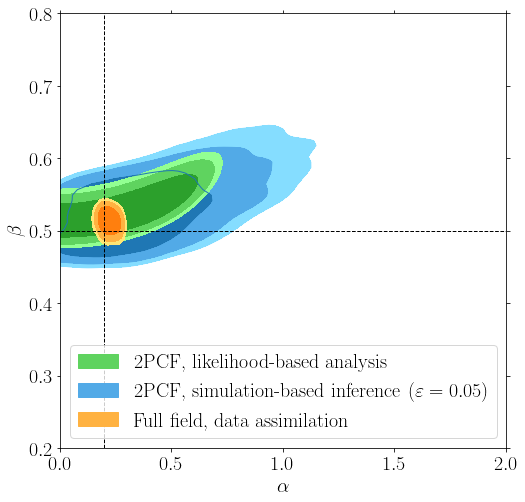

In [22]:
fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
# ax.set_xlim([0.4,2.0])
# ax.set_ylim([0.35,0.65])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]))
ax.contour(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]),linewidths=1)

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))

# Legend 1
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
plt.legend(handles=[patch1,patch2],loc='lower left')
plt.legend(handles=[patch1,patch2,patch3],loc='lower left')

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_da.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_da.png',dpi=100,bbox_inches="tight")